## Multivariate Time Series Forecasting with LSTM in Keras

In this exercise, we are using Air Quality dataset. 

This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather informaion including dew point, temparature, pressure, wind direction, wind speed and the cumulative hours of snow and rain. The complete feature list in the raw data is as follows:

1. No: row number
2. year: year of data in this row
3. month: month of data in this row
4. day: day of data in this row
5. hour: hour of data in this row
6. pm2.5: PM2.5 concentration
7. DEWP: Dew Point
8. TEMP: Temperature
9. PRES: Pressure
10. cbwd: Combined wind direction
11. Iws: Cumulated wind speed
12. Is: Cumulated hours of snow
13. Ir: Cumulated hours of rain

We can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

This dataset can be used to frame other forecasting problems. 

In [1]:
from pandas import read_csv
from datetime import datetime

# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('raw.csv', parse_dates = [['year', 'month', 'day', 'hour']], index_col = 0, date_parser = parse)

Observing the data below we can identify the following steps for data preparation:-

   1. The first 24 rows of pm2.5 are NaN. This has to be removed or replaced with a value.
   2. The first few columns representing (year, month, day, hour) can be parsed using a date_parser when read in a csv format. This can then be used to index a row as this is time series.
   3. The 'No' column is redundant and not necessary if datetime is used to index the rows.

In [5]:
dataset.head(30)

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0
2010-01-01 05:00:00,6,NaN,-19,-10.0,1017.0,NW,16.10,0,0
2010-01-01 06:00:00,7,NaN,-19,-9.0,1017.0,NW,19.23,0,0
2010-01-01 07:00:00,8,NaN,-19,-9.0,1017.0,NW,21.02,0,0
2010-01-01 08:00:00,9,NaN,-19,-9.0,1017.0,NW,24.15,0,0


In [6]:
dataset.drop('No', axis = 1, inplace = True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wind_spd', 'snow', 'rain']
dataset.index.name = 'date'

# mark all NA values with 0 
dataset['pollution'].fillna(0, inplace = True)

# drop the first 24 hours
dataset = dataset[24:]

# summarize the first 5 rows
print(dataset.head(5))

# save to file 
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wind_spd  snow  \
date                                                                        
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE      1.79     0   
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE      2.68     0   
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE      3.57     0   
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE      5.36     1   
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE      6.25     2   

                     rain  
date                       
2010-01-02 00:00:00     0  
2010-01-02 01:00:00     0  
2010-01-02 02:00:00     0  
2010-01-02 03:00:00     0  
2010-01-02 04:00:00     0  


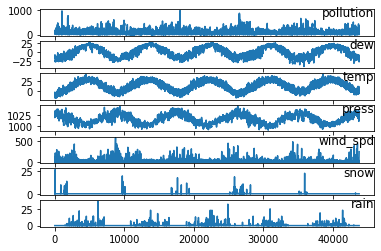

In [11]:
from matplotlib import pyplot

# load dataset
dataset = read_csv('pollution.csv', header=0 , index_col = 0)

# Converts your dataframe to numpy version
'''
For example,

df = pd.DataFrame({'age':    [ 3,  29],
                    'height': [94, 170],
                    'weight': [31, 115]})

df.values
array([[  3,  94,  31],
       [ 29, 170, 115]], dtype=int64)
       
'''

values = dataset.values

# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    # arg 1 - column name , arg 2 - offset of the title from the top of the axes
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1

pyplot.show()

%matplotlib inline

## LSTM Data Preparation

How to prepare the pollution dataset for the LSTM?
    
   Frame the dataset as a supervised learning problem and normalize the input variables.
    
   We will frame the supervised learning problem as predicting the pollution at the current hour(t) given the pollution measurement and weather conditions at the prior time step.
   
   This formulation is straightforward and just for this demonstration. Some alternate formulations:-
   * Predict the pollution for the next hour based on the weather conditions and pollution over the last 24 hours.
   * Predict the pollution for the next hour as above and given the “expected” weather conditions for the next hour.

We need to convert the time series data to a supervised learning format. We can do so by using a shift() function. Given a DataFrame, the shift() function can be used to create copies of columns that are pushed forward (rows of NaN values added to the front) or pulled back (rows of NaN values added to the end).

This is the behaviour required to create columns of lag observations as well as columns of forecast observations for a time series dataset in a supervised learning format.

For example,

In [12]:
from pandas import DataFrame
df = DataFrame()
df['t'] = [x for x in range(10)]
print(df)

   t
0  0
1  1
2  2
3  3
4  4
5  5
6  6
7  7
8  8
9  9


We can shift all of the obseervations down one step by inserting one new row at the top. Because the new row has no data, we can use NaN to represent "no data"

In [13]:
df['t'] = [x for x in range(10)]
df['t-1'] = df['t'].shift(1)
print(df)

   t  t-1
0  0  NaN
1  1  0.0
2  2  1.0
3  3  2.0
4  4  3.0
5  5  4.0
6  6  5.0
7  7  6.0
8  8  7.0
9  9  8.0


In [14]:
df = DataFrame()
df['t'] = [x for x in range(10)]
df['t+1'] = df['t'].shift(-1)
print(df)

   t  t+1
0  0  1.0
1  1  2.0
2  2  3.0
3  3  4.0
4  4  5.0
5  5  6.0
6  6  7.0
7  7  8.0
8  8  9.0
9  9  NaN


-----------End of example---------

The function takes four arguments:

* data: Sequence of observations as a list or 2D NumPy array. Required.
* n_in: Number of lag observations as input (X). Values may be between [1..len(data)] Optional. Defaults to 1.
* n_out: Number of observations as output (y). Values may be between [0..len(data)-1]. Optional. Defaults to 1.
* dropnan: Boolean whether or not to drop rows with NaN values. Optional. Defaults to True.

In [32]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from pandas import concat
# convert series to supervised learning

def series_to_supervised(data, n_in=1, n_out=1, dropnan = True ):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols , names = list() , list()
    
    # input sequence (t-n, ....., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1,...., t+n) 
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('val%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('val%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        
    # put it all together 
    agg = concat(cols, axis = 1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

# load dataset
dataset = read_csv('pollution.csv', header = 0, index_col = 0)
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),val1(t),val2(t),val3(t),val4(t),val5(t),val6(t),val7(t),val8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.000000,0.0


In [33]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1 , inplace = True)
reframed.shape

(43799, 9)

In [35]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),val1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658
...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048


## Model

First, we must split the prepared dataset into train and test sets. 

To speed up the training of the model for this demostration, we will only fir the model on the first year of data, then evaluate it on the remaining 4 years of data.

In [64]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :] 
test = values[n_train_hours:, :] 

# split into input and outputs
train_X, train_y = train[:,:-1], train[:,-1]
test_X, test_y = test[:,:-1], test[:,-1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

test_X.shape


(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


(35039, 1, 8)

(35039, 1, 8)
Train on 8760 samples, validate on 35039 samples
Epoch 1/50
8760/8760 - 1s - loss: 0.0633 - val_loss: 0.0489
Epoch 2/50
8760/8760 - 1s - loss: 0.0410 - val_loss: 0.0393
Epoch 3/50
8760/8760 - 1s - loss: 0.0228 - val_loss: 0.0287
Epoch 4/50
8760/8760 - 1s - loss: 0.0159 - val_loss: 0.0175
Epoch 5/50
8760/8760 - 1s - loss: 0.0148 - val_loss: 0.0146
Epoch 6/50
8760/8760 - 1s - loss: 0.0149 - val_loss: 0.0143
Epoch 7/50
8760/8760 - 1s - loss: 0.0148 - val_loss: 0.0144
Epoch 8/50
8760/8760 - 1s - loss: 0.0149 - val_loss: 0.0145
Epoch 9/50
8760/8760 - 1s - loss: 0.0149 - val_loss: 0.0145
Epoch 10/50
8760/8760 - 1s - loss: 0.0148 - val_loss: 0.0141
Epoch 11/50
8760/8760 - 1s - loss: 0.0146 - val_loss: 0.0139
Epoch 12/50
8760/8760 - 1s - loss: 0.0145 - val_loss: 0.0138
Epoch 13/50
8760/8760 - 1s - loss: 0.0145 - val_loss: 0.0138
Epoch 14/50
8760/8760 - 1s - loss: 0.0145 - val_loss: 0.0136
Epoch 15/50
8760/8760 - 1s - loss: 0.0145 - val_loss: 0.0137
Epoch 16/50
8760/8760 - 1s - lo

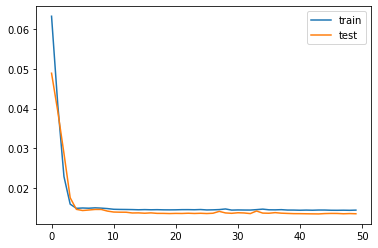

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense 
print(test_X.shape)
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer ='adam')

# fit network
history = model.fit(train_X, train_y, epochs = 50, batch_size = 72, validation_data=(test_X, test_y), verbose=2, shuffle= False)

# plot history 
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')

pyplot.legend()
pyplot.show()

In [66]:
from numpy import concatenate
# make a prediction
print(test_X.shape)
yhat = model.predict(test_X)


(35039, 1, 8)


In [67]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [68]:
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshaped[:,1:]), axis = 1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X_reshaped[:,1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)

inv_y = inv_y[:,0]

# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.556
